## Importing information into data frame

In [2]:
from __future__ import print_function, division
import requests
import re
import pandas as pd
import dateutil.parser
import datetime
import pickle
import patsy
import numpy as np
from pprint import pprint
from bs4 import BeautifulSoup
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from seaborn import plt
%matplotlib inline

# import PolynomialFeatures and make_pipeline for Polynomial Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold

def to_date(datestring):
    datetime = dateutil.parser.parse(datestring)
    return datetime.date()

def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return int(moneystring)

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None

def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text 
    else:
        return None


/Users/maxkneissl/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Create list of movie URLs for all movies in 2016

In [2]:
url = "http://www.boxofficemojo.com/yearly/chart/?view2=worldwide&yr=2016&p=.htm"

response=requests.get(url)
page=response.text

soup=BeautifulSoup(page,"lxml")

tables=soup.find_all("table")
rows=[row for row in tables[2].find_all('tr')][308:408]

mov_urls2 = []
for j in rows:
    snippet = j.find('a')['href']
    mov_urls2.append(snippet.split("=")[1])


print(mov_urls2[:10])

['fireworkswednesday.htm', 'noonelifeeasy.htm', 'dontcrossthatriver.htm', 'jtleroystory.htm', 'mountainsmaydepart.htm', 'cockandbull.htm', 'astreetcatnamedbob.htm', 'lescowboys.htm', 'bestfriendswedding2016.htm', 'saalakhadoos.htm']


## Create list of movie URLs for all movies in 2015

In [235]:
url = "http://www.boxofficemojo.com/yearly/chart/?view2=worldwide&yr=2015&p=.htm"

response=requests.get(url)
page=response.text

soup=BeautifulSoup(page,"lxml")

tables=soup.find_all("table")
rows=[row for row in tables[2].find_all('tr')][3:450]

mov_urls15 = []
for j in rows:
    snippet = j.find('a')['href']
    mov_urls15.append(snippet.split("=")[1])


print(mov_urls15[:10])

['starwars7.htm', 'jurassicpark4.htm', 'fast7.htm', 'avengers2.htm', 'minions.htm', 'bond24.htm', 'pixar2014.htm', 'mi5.htm', 'hungergames4.htm', 'scott2016.htm']


## Function to scrape individual movie page

In [236]:
#mov_names = ["biglebowski", "seriousman", "intolerablecruelty", "burnafterreading"]

movies_2015_df = pd.DataFrame(columns = ['movie_title', 'domestic_total_gross',
           'release_date', 'runtime_mins', 'rating', "no_countries", "widest_release", "days_in_release"])

def scrape_movie():
        
    for i in mov_urls15:       
        
        url = 'http://www.boxofficemojo.com/movies/?id=' + i        
        response = requests.get(url) #Pulls data
        page = response.text
        soup = BeautifulSoup(page,"lxml") # lxml is an optional add-on

        # Title
        title_string = soup.find('title').text
        title = title_string.split('(')[0].strip()

        # Finding domestic lifetime gross from lower table
        try:
            rev_table = soup.find_all("table")[9]
            dom_lt_gross = rev_table.find_all("td")[1].text
            dom_lt_gross = dom_lt_gross.replace("$", "").replace(",", "")
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            dom_lt_gross = np.nan

        # Release Date
        raw_release_date = get_movie_value(soup,'Release Date')
        release_date = raw_release_date

        # Runtime
        try:
            raw_runtime = get_movie_value(soup,'Runtime')
            runtime = runtime_to_minutes(raw_runtime)
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            runtime = np.nan


        # Rating
        rating = get_movie_value(soup,'MPAA Rating')
        
        # Countries
        try:
            int_url = "http://www.boxofficemojo.com/movies/?page=intl&id=" + i
            int_response=requests.get(int_url)
            int_page=int_response.text
            int_soup=BeautifulSoup(int_page,"lxml")
            country_table = int_soup.find_all("table")[7]
            no_countries = len(country_table.find_all("tr")) - 3
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            no_countries = np.nan

        
        # Theaters (Widest Release)
        try:
            wr_regex = re.compile('Release:')
            wr = soup.body.find(text=wr_regex)
            wr_int = wr.findNext("td").text.split(" ")[0].replace(",", "")
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            wr_int = np.nan

            
        # Release Time (in days)
        try:
            ir_regex = re.compile('In Release:')
            ir = soup.body.find(text=ir_regex)
            ir_int = ir.findNext("td").text.split(" ")[0].replace(",", "")
        except(TypeError, KeyError, AttributeError, IndexError) as e:
            ir_int = np.nan
        
        # New Row
        new_row = [title, dom_lt_gross, release_date, runtime, rating, no_countries, wr_int, ir_int]

        movies_2015_df.loc[len(movies_2015_df)] = new_row


scrape_movie()

print("movies_2015_df:")
movies_2015_df.head(10)

movies_2015_df:


,movie_title,domestic_total_gross,release_date,runtime_mins,rating,no_countries,widest_release,days_in_release
0,Star Wars: The Force Awakens,Domestic:,"December 18, 2015",136,PG-13,62.0,4134,168
1,Jurassic World,652270625,"June 12, 2015",124,PG-13,65.0,4291,NaN
2,Furious 7,353007020,"April 3, 2015",137,PG-13,67.0,4022,NaN
3,Avengers: Age of Ultron,459005868,"May 1, 2015",141,PG-13,65.0,4276,161
4,Minions,336045770,"July 10, 2015",91,PG,66.0,4311,161
5,Spectre,200074609,"November 6, 2015",148,PG-13,65.0,3929,154
6,Inside Out,356461711,"June 19, 2015",94,PG,65.0,4158,175
7,Mission: Impossible - Rogue Nation,195042377,"July 31, 2015",130,PG-13,63.0,3988,91
8,The Hunger Games: Mockingjay - Part 2,281723902,"November 20, 2015",137,PG-13,61.0,4175,98
9,The Martian,228433663,"October 2, 2015",141,PG-13,68.0,3854,168


In [237]:
movies_2015_df.info

<bound method DataFrame.info of                                       movie_title domestic_total_gross  \
0                    Star Wars: The Force Awakens            Domestic:   
1                                  Jurassic World            652270625   
2                                       Furious 7            353007020   
3                         Avengers: Age of Ultron            459005868   
4                                         Minions            336045770   
5                                         Spectre            200074609   
6                                      Inside Out            356461711   
7              Mission: Impossible - Rogue Nation            195042377   
8           The Hunger Games: Mockingjay - Part 2            281723902   
9                                     The Martian            228433663   
10                           Fifty Shades of Grey            166167230   
11                                     Cinderella            201151353   
12    

In [216]:
movies_2016_df.reset_index(inplace=True)
movies_2016_df.tail()

,level_0,index,movie_title,domestic_total_gross,release_date,runtime_mins,rating,no_countries,widest_release,days_in_release
400,400,95,In Her Name,1623,"December 2, 2016",87,Unrated,3.0,2,7
401,401,96,Next Time I'll Aim for the Heart,815,"April 1, 2016",111,Unrated,3.0,1,21
402,402,97,The Student and Mr. Henri,761,"August 19, 2016",98,Unrated,4.0,1,7
403,403,98,Down By Love,675,"August 19, 2016",100,Not Yet Rated,4.0,2,7
404,404,99,News From Planet Mars,310,"July 22, 2016",101,Unrated,1.0,1,7


In [22]:
# format columns

def integ(floatt):
    try:
        return int(floatt)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')

def floatt(grossstr):
    try:
        return float(grossstr)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')


def tdelta(days):
    try:
        return datetime.timedelta(days)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')


def todate(strdate):
    try:
        return dateutil.parser.parse(strdate)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')


def tdelta(days):
    try:
        return datetime.timedelta(days)
    except(TypeError, KeyError, AttributeError, IndexError, ValueError) as e:
        return float('NaN')


def format_series(df):
    # Convert runtime into mins
    df["runtime_mins"] = df["runtime_mins"].apply(integ)
    # Convert widest_release to int
    df["widest_release"] = df["widest_release"].apply(integ)
    # Convert days_in_release to int
    df["days_in_release"] = df["days_in_release"].apply(integ)
    # Convert domestic_total_gross to float
    df["domestic_total_gross"] = df["domestic_total_gross"].apply(floatt)
    # Convert release_date to datetime.date
    df["release_date"] = df["release_date"].apply(todate)
    # Calculate close_date from release_date and days_in_release
    #df["close_date"] = df["release_date"] + df["days_in_release"].apply(tdelta)

#format_series(movies_2015_df)

In [239]:
movies_2015_df.head()

,movie_title,domestic_total_gross,release_date,runtime_mins,rating,no_countries,widest_release,days_in_release
0,Star Wars: The Force Awakens,NaN,2015-12-18,136,PG-13,62.0,4134.0,168.0
1,Jurassic World,652270625.0,2015-06-12,124,PG-13,65.0,4291.0,NaN
2,Furious 7,353007020.0,2015-04-03,137,PG-13,67.0,4022.0,NaN
3,Avengers: Age of Ultron,459005868.0,2015-05-01,141,PG-13,65.0,4276.0,161.0
4,Minions,336045770.0,2015-07-10,91,PG,66.0,4311.0,161.0


In [233]:
movies_2016_df.to_pickle('movies_2016_df.pkl')

In [6]:
with open('/Users/maxkneissl/Repositories/Metis_Course/nyc17_ds10/student_submissions/projects/02-luther/kneissl_max/movies_2016_df.pkl', 'rb') as picklefile: 
    movies_2016_df = pickle.load(picklefile)

with open('/Users/maxkneissl/Repositories/Metis_Course/nyc17_ds10/student_submissions/projects/02-luther/kneissl_max/movies_2015_df.pkl', 'rb') as picklefile: 
    movies_2015_df = pickle.load(picklefile)

In [15]:
movies_2016_df.drop(["level_0", 'index'], axis=1, inplace=True)

In [154]:
movies_total_df = movies_2016_df.append(movies_2015_df)

In [155]:
# Convert runtime to min
movies_total_df["runtime_mins"] = movies_total_df["runtime_mins"].apply(pd.to_numeric, errors='coerce')

## Regression analysis

In [156]:
# removed extreme outlier 
movies_total_df = movies_total_df[movies_total_df.runtime_mins != 729.0]

In [157]:
# drop nas
movies_total_df.dropna(inplace=True)

In [158]:
# Still over 750 entries
len(movies_total_df)

778

In [20]:
# Pickle movies_total_df
movies_total_df.to_pickle('movies_total_adj_df.pkl')

In [64]:
# Unpickle movies_total_df
with open('movies_total_adj_df.pkl', 'rb') as picklefile: 
    movies_total_df = pickle.load(picklefile)

In [4]:
movies_total_df.head()

,movie_title,domestic_total_gross,release_date,runtime_mins,rating,no_countries,widest_release,days_in_release,log_dtg,log_runtime_mins,log_no_countries,log_widest_release,log_days_in_release
0,Captain America: Civil War,408084349.0,2016-05-06,147.0,PG-13,47.0,4226.0,140.0,19.826984,4.990433,3.850148,8.349011,4.941642
1,Finding Dory,486295561.0,2016-06-17,103.0,PG,50.0,4305.0,175.0,20.002327,4.634729,3.912023,8.367532,5.164786
2,Zootopia,341268248.0,2016-03-04,108.0,PG,59.0,3959.0,154.0,19.648179,4.682131,4.077537,8.283747,5.036953
3,Rogue One: A Star Wars Story,503214018.0,2016-12-16,133.0,PG-13,51.0,4157.0,33.0,20.036526,4.890349,3.931826,8.332549,3.496508
4,The Jungle Book,364001123.0,2016-04-15,105.0,PG,59.0,4144.0,168.0,19.712668,4.653960,4.077537,8.329417,5.123964


In [20]:
movies_total_df.corr()

,domestic_total_gross,runtime_mins,no_countries,widest_release,days_in_release,log_dtg,log_runtime_mins,log_no_countries,log_widest_release,log_days_in_release
domestic_total_gross,1.000000,0.110755,0.607817,0.692935,0.353263,0.589046,0.113048,0.472852,0.496850,0.311443
runtime_mins,0.110755,1.000000,0.062970,0.041196,-0.092029,0.152308,0.991450,0.044613,0.097631,-0.079781
no_countries,0.607817,0.062970,1.000000,0.835154,0.364568,0.745801,0.081030,0.896925,0.737074,0.389790
widest_release,0.692935,0.041196,0.835154,1.000000,0.321135,0.845768,0.053535,0.717898,0.849687,0.374752
days_in_release,0.353263,-0.092029,0.364568,0.321135,1.000000,0.444590,-0.096858,0.336597,0.297714,0.896586
log_dtg,0.589046,0.152308,0.745801,0.845768,0.444590,1.000000,0.155995,0.710668,0.941710,0.516877
log_runtime_mins,0.113048,0.991450,0.081030,0.053535,-0.096858,0.155995,1.000000,0.063559,0.104658,-0.074789
log_no_countries,0.472852,0.044613,0.896925,0.717898,0.336597,0.710668,0.063559,1.000000,0.718106,0.377389
log_widest_release,0.496850,0.097631,0.737074,0.849687,0.297714,0.941710,0.104658,0.718106,1.000000,0.365795
log_days_in_release,0.311443,-0.079781,0.389790,0.374752,0.896586,0.516877,-0.074789,0.377389,0.365795,1.000000


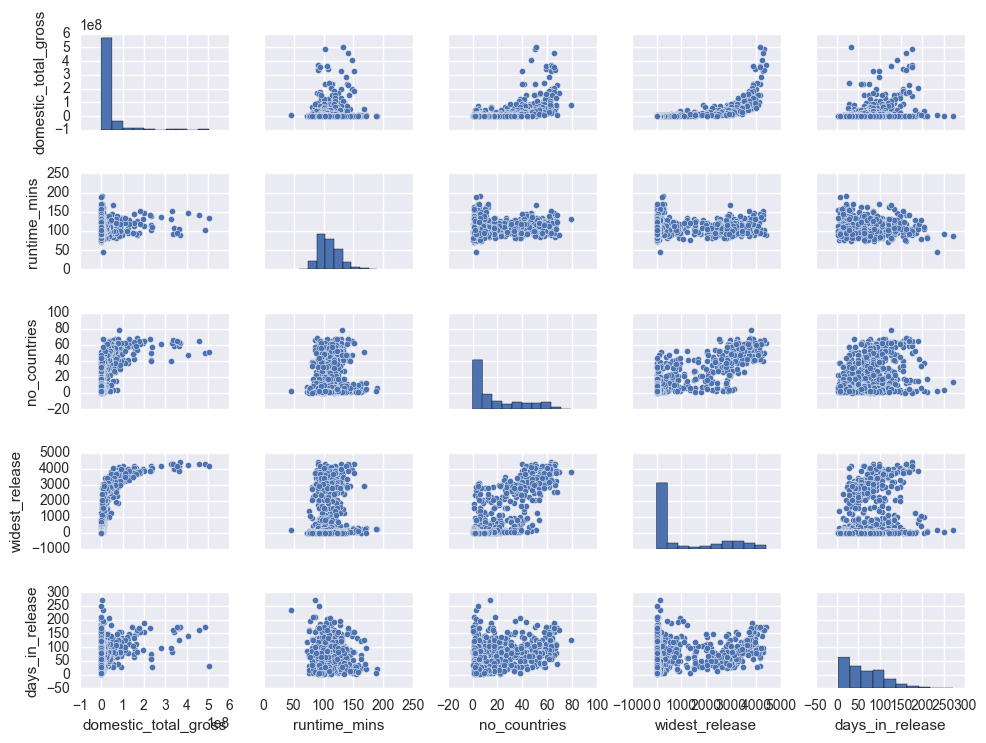

In [6]:
sns.pairplot(movies_total_df.dropna(), size = 1.5, aspect=1.3)
#sns.plt.show()

In [5]:
movies_total_df.columns

Index(['movie_title', 'domestic_total_gross', 'release_date', 'runtime_mins',
       'rating', 'no_countries', 'widest_release', 'days_in_release',
       'log_dtg', 'log_runtime_mins', 'log_no_countries', 'log_widest_release',
       'log_days_in_release'],
      dtype='object')

In [6]:
lr = LinearRegression() # creates empty model
X = movies_total_df[['runtime_mins', 'no_countries', 'widest_release', 'days_in_release']]
y = movies_total_df['domestic_total_gross']
lr.fit(X,y) # fit model to full dataset
lr.score(X,y) # print out R^2 for model

0.50929349199502139

In [7]:
y, X = patsy.dmatrices('domestic_total_gross ~ runtime_mins + no_countries + widest_release + days_in_release', data=movies_total_df, return_type="dataframe")
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     domestic_total_gross   R-squared:                       0.509
Model:                              OLS   Adj. R-squared:                  0.507
Method:                   Least Squares   F-statistic:                     200.6
Date:                  Wed, 25 Jan 2017   Prob (F-statistic):          6.29e-118
Time:                          11:28:16   Log-Likelihood:                -14764.
No. Observations:                   778   AIC:                         2.954e+04
Df Residuals:                       773   BIC:                         2.956e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept       -5.359e+07   9.75e+06     -5.494      0.000     -7.27e+07 -3.44e+07
runtime_mins     3.237e+05   8.46e+04      3.828      0.000      1.58e+05   4.9e+05
no_countries     1.142e+05   1.39e+05      0.818      0.413      -1.6e+05  3.88e+05
widest_release   2.606e+04   1965.502     13.260      0.000      2.22e+04  2.99e+04
days_in_release  1.989e+05   3.54e+04      5.612      0.000      1.29e+05  2.69e+05
==============================================================================
Omnibus:                      733.586   Durbin-Watson:                   0.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28853.863
Skew:                           4.260   Prob(JB):                         0.00
Kurtosis:                      31.592   Cond. No.                     1.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

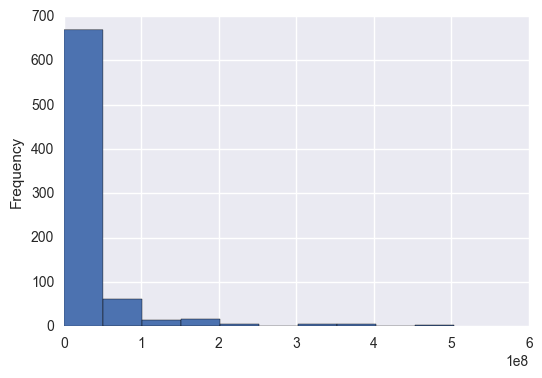

In [8]:
movies_total_df.domestic_total_gross.plot.hist()

In [9]:
movies_total_df['log_dtg'] = np.log(movies_total_df['domestic_total_gross'])

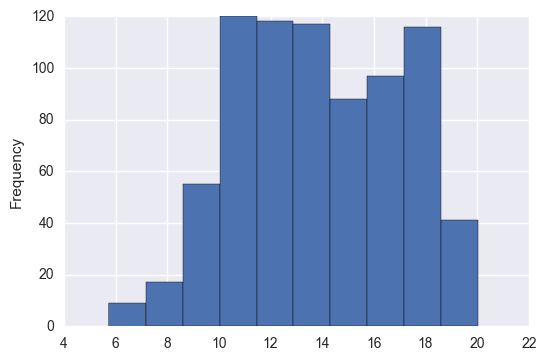

In [10]:
movies_total_df.log_dtg.plot.hist()

In [11]:
# Run regression again on log domestic total gross
y2, X2 = patsy.dmatrices('log_dtg ~ runtime_mins + no_countries + widest_release + days_in_release', data=movies_total_df, return_type="dataframe")
model2 = sm.OLS(y2, X2)
fit2 = model2.fit()
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_dtg   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     642.4
Date:                Wed, 25 Jan 2017   Prob (F-statistic):          4.97e-244
Time:                        11:28:32   Log-Likelihood:                -1419.6
No. Observations:                 778   AIC:                             2849.
Df Residuals:                     773   BIC:                             2873.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           8.5615      0.347     24.684      0.000         7.881     9.242
runtime_mins        0.0237      0.003      7.878      0.000         0.018     0.030
no_countries        0.0081      0.005      1.641      0.101        -0.002     0.018
widest_release      0.0016   6.99e-05     23.224      0.000         0.001     0.002
days_in_release     0.0137      0.001     10.859      0.000         0.011     0.016
==============================================================================
Omnibus:                       22.434   Durbin-Watson:                   0.728
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.616
Skew:                          -0.409   Prob(JB):                     7.44e-06
Kurtosis:                       3.244   Cond. No.                     1.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
movies_total_df['log_runtime_mins'] = np.log(movies_total_df['runtime_mins'])
movies_total_df['log_no_countries'] = np.log(movies_total_df['no_countries'])
movies_total_df['log_widest_release'] = np.log(movies_total_df['widest_release'])
movies_total_df['log_days_in_release'] = np.log(movies_total_df['days_in_release'])

In [12]:
movies_total_df.corr()['log_dtg'].sort_values(ascending=False)
# Accordingly I should use as features: - log_widest_... - no_count... - log_days... - log_runtime...

log_dtg                 1.000000
log_widest_release      0.941710
widest_release          0.845768
no_countries            0.745801
log_no_countries        0.710668
domestic_total_gross    0.589046
log_days_in_release     0.516877
days_in_release         0.444590
log_runtime_mins        0.155995
runtime_mins            0.152308
Name: log_dtg, dtype: float64

In [103]:
# Run regression again on log domestic total gross and log features
y3, X3 = patsy.dmatrices('log_dtg ~ log_widest_release', data=movies_total_df, return_type="dataframe")
model3 = sm.OLS(y3, X3)
fit3 = model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_dtg   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     6080.
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        15:30:55   Log-Likelihood:                -1141.7
No. Observations:                 778   AIC:                             2287.
Df Residuals:                     776   BIC:                             2297.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              8.1415      0.083     98.526      0.000         7.979     8.304
log_widest_release     1.1656      0.015     77.975      0.000         1.136     1.195
==============================================================================
Omnibus:                       36.779   Durbin-Watson:                   1.449
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.765
Skew:                          -0.272   Prob(JB):                     7.88e-18
Kurtosis:                       4.461   Cond. No.                         12.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Introduce polynomial features 

In [122]:
movies_total_df.head()

,movie_title,domestic_total_gross,release_date,runtime_mins,rating,no_countries,widest_release,days_in_release,log_dtg,log_runtime_mins,...,log_widest_release_2,log_widest_release_3,log_widest_release_4,log_widest_release_5,log_widest_release_6,log_widest_release_7,rating_short,rating_short_PG13,rating_short_R,rating_short_Unrated
0,Captain America: Civil War,408084349.0,2016-05-06,147.0,PG-13,47.0,4226.0,140.0,19.826984,4.990433,...,69.705988,581.976074,4858.924761,40567.217243,338696.151041,2.827778e+06,PG-13,1.0,0.0,0.0
1,Finding Dory,486295561.0,2016-06-17,103.0,PG,50.0,4305.0,175.0,20.002327,4.634729,...,70.015599,585.857792,4902.184068,41019.184102,343229.352686,2.871983e+06,PG,0.0,0.0,0.0
2,Zootopia,341268248.0,2016-03-04,108.0,PG,59.0,3959.0,154.0,19.648179,4.682131,...,68.620460,568.434514,4708.767554,39006.237908,323117.796388,2.676626e+06,PG,0.0,0.0,0.0
3,Rogue One: A Star Wars Story,503214018.0,2016-12-16,133.0,PG-13,51.0,4157.0,33.0,20.036526,4.890349,...,69.431372,578.540304,4820.715394,40168.846939,334708.882949,2.788978e+06,PG-13,1.0,0.0,0.0
4,The Jungle Book,364001123.0,2016-04-15,105.0,PG,59.0,4144.0,168.0,19.712668,4.653960,...,69.379184,577.888139,4813.471167,40093.407528,333954.701587,2.781648e+06,PG,0.0,0.0,0.0


In [97]:
movies_total_df['log_widest_release_2'] = movies_total_df['log_widest_release']**2
movies_total_df['log_widest_release_3'] = movies_total_df['log_widest_release']**3
movies_total_df['log_widest_release_4'] = movies_total_df['log_widest_release']**4
movies_total_df['log_widest_release_5'] = movies_total_df['log_widest_release']**5
#movies_total_df['log_widest_release_6'] = movies_total_df['log_widest_release']**6
#movies_total_df['log_widest_release_7'] = movies_total_df['log_widest_release']**7

In [126]:
# Run regression again on log domestic total gross and log features
y3, X3 = patsy.dmatrices('log_dtg ~ log_widest_release + log_widest_release_2 + log_widest_release_3 + log_widest_release_4 + log_widest_release_5 + log_days_in_release + runtime_mins + rating_short_PG13 + rating_short_R + rating_short_Unrated', data=movies_total_df, return_type="dataframe")
model3 = sm.OLS(y3, X3)
fit3 = model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_dtg   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     1165.
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        17:32:51   Log-Likelihood:                -905.98
No. Observations:                 778   AIC:                             1834.
Df Residuals:                     767   BIC:                             1885.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                4.7746      0.277     17.210      0.000         4.230     5.319
log_widest_release       0.1452      0.396      0.367      0.714        -0.631     0.922
log_widest_release_2     0.3804      0.299      1.270      0.204        -0.207     0.968
log_widest_release_3    -0.0276      0.091     -0.303      0.762        -0.207     0.151
log_widest_release_4    -0.0068      0.012     -0.566      0.572        -0.030     0.017
log_widest_release_5     0.0008      0.001      1.335      0.182        -0.000     0.002
log_days_in_release      0.7329      0.036     20.596      0.000         0.663     0.803
runtime_mins             0.0112      0.002      6.632      0.000         0.008     0.015
rating_short_PG13        0.1101      0.118      0.934      0.350        -0.121     0.341
rating_short_R          -0.0018      0.118     -0.016      0.988        -0.234     0.230
rating_short_Unrated     0.4200      0.134      3.137      0.002         0.157     0.683
==============================================================================
Omnibus:                       56.361   Durbin-Watson:                   1.717
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.820
Skew:                           0.118   Prob(JB):                     3.09e-53
Kurtosis:                       5.721   Cond. No.                     3.43e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.43e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Diagnose Assumptions

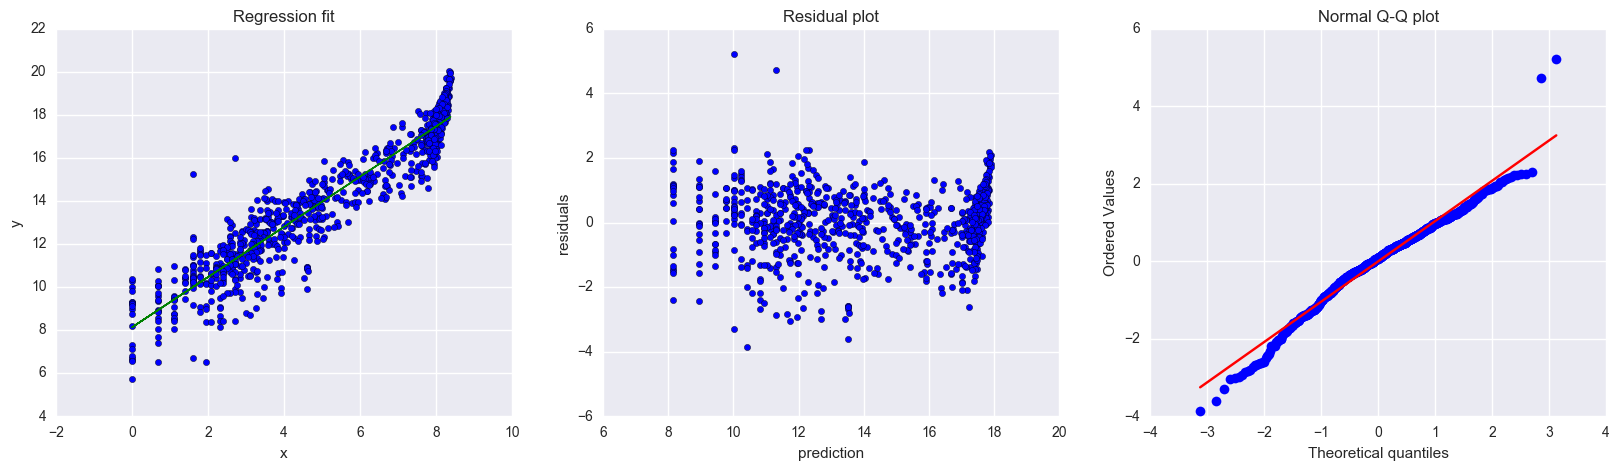

In [87]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='green',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

s= 778

diagnostic_plot(movies_total_df['log_widest_release'], movies_total_df['log_dtg'])

## Reduce errors by introducing polynomial features 

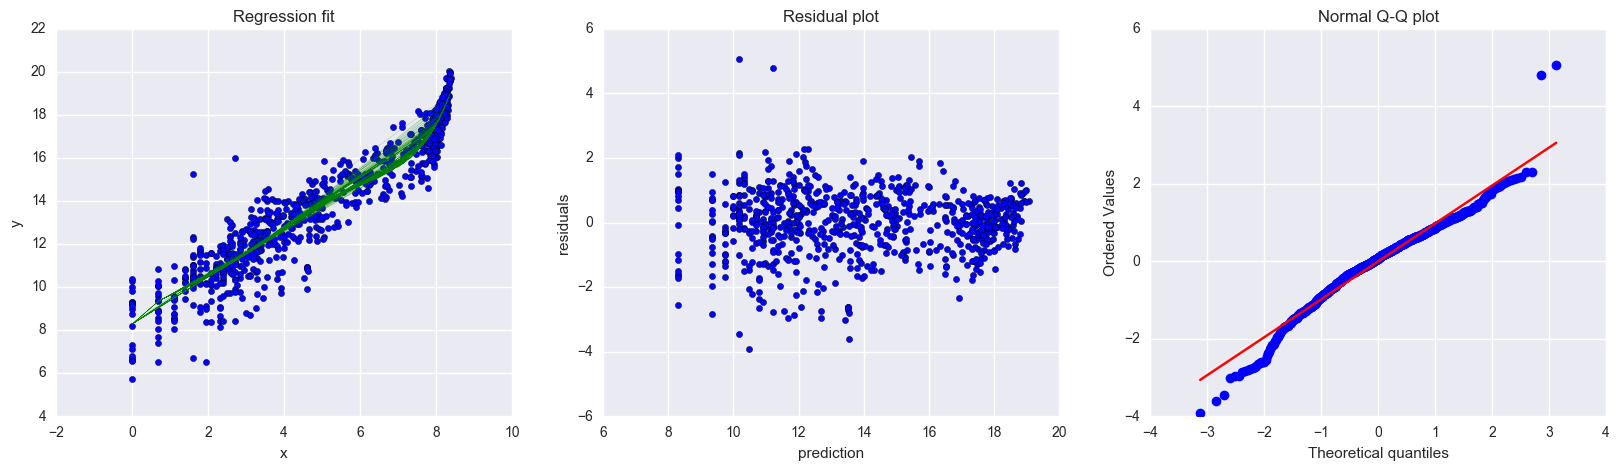

In [100]:
import scipy.stats as stats

def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    #rgr = LinearRegression()
    #rgr.fit(x.reshape(s,1),y)
    #pred = rgr.predict(x.reshape(s,1))
    est = make_pipeline(PolynomialFeatures(5), LinearRegression())
    est.fit(x.reshape(s,1), movies_total_df["log_dtg"])
       
    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    #plt.plot(x, pred, color='blue',linewidth=1)
    plt.plot(x, est.predict(x[:, np.newaxis]), color='green',linewidth=0.1)
    
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - est.predict(x[:, np.newaxis])
    plt.scatter(est.predict(x[:, np.newaxis]), res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

s= 778

diagnostic_plot(x=movies_total_df['log_widest_release'], y=movies_total_df['log_dtg'])

## Dummy variables from rating

In [33]:
# Simplify rating

In [112]:
# Copy rating column
movies_total_df["rating_short"] = movies_total_df["rating"]

In [113]:
movies_total_df["rating_short"].replace(['Not Yet Rated', 'Unknown', 'G', 'NC-17'], ['Unrated', 'Unrated', 'Unrated', 'Unrated'], inplace=True)

In [114]:
print(movies_total_df.rating_short.value_counts())
print('\n')
print(len(movies_total_df.rating_short.value_counts()))

Unrated    278
R          262
PG-13      177
PG          61
Name: rating_short, dtype: int64


4


In [115]:
X=patsy.dmatrix('rating_short',data=movies_total_df,return_type='dataframe')
X.head()

,Intercept,rating_short[T.PG-13],rating_short[T.R],rating_short[T.Unrated]
0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [120]:
movies_total_df[['rating_short_PG13', 'rating_short_R', 'rating_short_Unrated']] = X[['rating_short[T.PG-13]', 'rating_short[T.R]', 'rating_short[T.Unrated]']]

In [50]:
#y, X = patsy.dmatrices('log_dtg ~ log_widest_release + no_countries + Intercept + rating_short[T.PG-13] + rating_short[T.R] + rating_short[T.Unrated]', data=movies_total_df, return_type="dataframe")
y = movies_total_df["log_dtg"]
X = movies_total_df[['log_widest_release', 'no_countries', 'Intercept', 'rating_short[T.PG-13]', 'rating_short[T.R]', 'rating_short[T.Unrated]']]
model = sm.OLS(y, X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_dtg   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     2426.
Date:                Wed, 25 Jan 2017   Prob (F-statistic):               0.00
Time:                        12:18:14   Log-Likelihood:                -2054.6
No. Observations:                1456   AIC:                             4121.
Df Residuals:                    1450   BIC:                             4153.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
log_widest_release          1.0471      0.017     63.456      0.000         1.015     1.079
no_countries                0.0172      0.002      8.976      0.000         0.013     0.021
Intercept                   8.5916      0.127     67.881      0.000         8.343     8.840
rating_short[T.PG-13]      -0.0666      0.108     -0.618      0.537        -0.278     0.145
rating_short[T.R]          -0.3497      0.105     -3.324      0.001        -0.556    -0.143
rating_short[T.Unrated]    -0.1115      0.114     -0.981      0.327        -0.335     0.111
==============================================================================
Omnibus:                       90.267   Durbin-Watson:                   0.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              272.182
Skew:                          -0.273   Prob(JB):                     7.88e-60
Kurtosis:                       5.047   Cond. No.                         226.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Regularization

In [138]:
movies_total_df.head()

,movie_title,domestic_total_gross,release_date,runtime_mins,rating,no_countries,widest_release,days_in_release,log_dtg,log_runtime_mins,log_no_countries,log_widest_release,log_days_in_release
0,Captain America: Civil War,408084349.0,2016-05-06,147.0,PG-13,47.0,4226.0,140.0,19.826984,4.990433,3.850148,8.349011,4.941642
1,Finding Dory,486295561.0,2016-06-17,103.0,PG,50.0,4305.0,175.0,20.002327,4.634729,3.912023,8.367532,5.164786
2,Zootopia,341268248.0,2016-03-04,108.0,PG,59.0,3959.0,154.0,19.648179,4.682131,4.077537,8.283747,5.036953
3,Rogue One: A Star Wars Story,503214018.0,2016-12-16,133.0,PG-13,51.0,4157.0,33.0,20.036526,4.890349,3.931826,8.332549,3.496508
4,The Jungle Book,364001123.0,2016-04-15,105.0,PG,59.0,4144.0,168.0,19.712668,4.653960,4.077537,8.329417,5.123964


In [116]:
X = movies_total_df[["log_widest_release", "no_countries", "log_days_in_release", "log_runtime_mins"]]
y = movies_total_df["log_dtg"]

In [117]:
#X = X.reshape((778,1))
X.shape

(778, 4)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

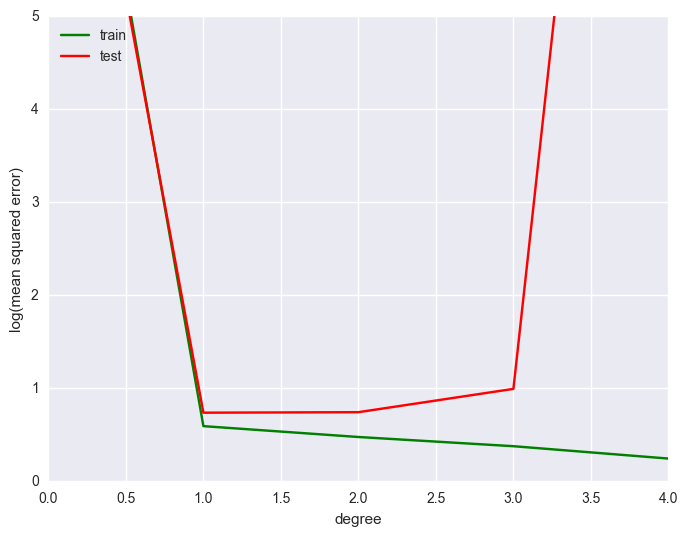

In [140]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error

# Step through degrees from 0 to 9 and store the training and test (generalization) error.
# create array of zeros,
train_error = np.empty(5)
test_error = np.empty(5)

for degree in range(5):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(5), train_error, color='green', label='train')
plt.plot(np.arange(5), test_error, color='red', label='test')
plt.ylim((0, 5))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')